# PHI Data Tutorial

## Solar Orbiter 8th Workshop (Belfast, UK) - 16th September 2022

### Jonas Sinjan (PhD Student at Max Planck Institute for Solar System Research, Goettingen, Germany)

#### For questions you can reach me by email: sinjan@mps.mpg.de

#### *with many thanks to Daniele Calchetti, Gherardo Valori and the SO/PHI team*

<img src="./data_tutorial_files/philogo-1.png" width="220" align="left"/>

In [1]:
import sunpy_soar
from sunpy.net import Fido
import sunpy.net.attrs as a
import sunpy.map

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import time

import astropy
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from reproject import reproject_adaptive

from belfast_helper import plot_fdt_phys_obs, plot_hrt_phys_obs, get_wv_arr_and_ic_wv, plot_fdt_stokes, plot_hrt_stokes, plot_hrt_noise_both

In [2]:
%matplotlib inline

In [3]:
print('astropy version:', astropy.__version__)
print('sunpy version: ', sunpy.__version__)

astropy version: 4.3.1
sunpy version:  3.1.0


# 1. Load data

First we will load SO/PHI-HRT and SO/PHI-FDT Data from the SOAR (Solar Orbiter Archive) using `sunpy` and `sunpy_soar`.

This is searching for data around the time of the Inferior Sun conjunction (when SO crossed the Sun-Earth line)

In [4]:
# # Create search attributes (no phi data in SOAR atm)
# instrument = a.Instrument('PHI')
# time = a.Time('2022-03-07', '2022-03-08')
# level = a.Level(2)
# product = a.soar.Product('hrt_blos')

# # Do search
# result = Fido.search(instrument & time & level & product)
# print(result)

# # Download files
# files = Fido.fetch(result)
# print(files)

In [5]:
fdt_dir = "/data/slam/home/sinjan/hmi_hrt_cc/fdt_files/"
hrt_dir = "/data/solo/phi/data/fmdb/public/l2/2022-03-07/"
hmi_dir = "/data/slam/home/sinjan/hmi_hrt_cc/hmi_files/blos_45/"

## FDT (Full Disc Telescope)

In [6]:
#load directly from fits files as backup
fdt_blos_arr = fits.getdata(fdt_dir + "solo_L2_phi-fdt-blos_20220131T143008_V202206301253_0241310515.fits")
fdt_bmag_arr = fits.getdata(fdt_dir + "solo_L2_phi-fdt-bmag_20220131T143008_V202206301253_0241310515.fits.gz")
fdt_binc_arr = fits.getdata(fdt_dir + "solo_L2_phi-fdt-binc_20220131T143008_V202206301253_0241310515.fits.gz")
fdt_bazi_arr = fits.getdata(fdt_dir + "solo_L2_phi-fdt-bazi_20220131T143008_V202206301253_0241310515.fits.gz")
fdt_vlos_arr = fits.getdata(fdt_dir + "solo_L2_phi-fdt-vlos_20220131T143008_V202206301253_0241310515.fits.gz")
fdt_icnt_arr = fits.getdata(fdt_dir + "solo_L2_phi-fdt-icnt_20220131T143008_V202206301253_0241310515.fits.gz")
fdt_stokes_arr = fits.getdata(fdt_dir + "solo_L2_phi-fdt-stokes_20220131T143008_V202206301253_0241310515.fits.gz")

Sunpy integration here is important. These fits files can be read into `sunpy` `Map` objects, like you have seen earlier.

In [7]:
fdt_blos_map = sunpy.map.Map(fdt_dir + "solo_L2_phi-fdt-blos_20220131T143008_V202206301253_0241310515.fits")
fdt_blos_map.plot_settings['norm'].vmin = -100
fdt_blos_map.plot_settings['norm'].vmax = 100 
fdt_blos_map.plot_settings['cmap'] = plt.get_cmap('gray')

In [8]:
#rotate FDT for Solar North to point up
fdt_blos_map = fdt_blos_map.rotate(recenter = True)

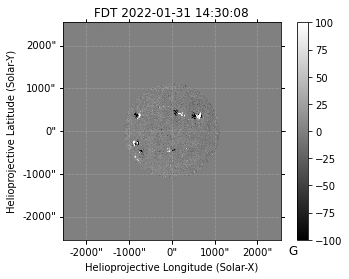

In [9]:
fdt_blos_map.peek()

## HRT (High Resolution Telescope)

If the SOAR query timed out, here you can load the datasets from the local folder provided as back up

In [10]:
#load directly from fits files as backup
hrt_blos_arr = fits.getdata(hrt_dir + "solo_L2_phi-hrt-blos_20220307T000009_V202206021608_0243070101.fits.gz")
hrt_bmag_arr = fits.getdata(hrt_dir + "solo_L2_phi-hrt-bmag_20220307T000009_V202206021608_0243070101.fits.gz")
hrt_binc_arr = fits.getdata(hrt_dir + "solo_L2_phi-hrt-binc_20220307T000009_V202206021608_0243070101.fits.gz")
hrt_bazi_arr = fits.getdata(hrt_dir + "solo_L2_phi-hrt-bazi_20220307T000009_V202206021608_0243070101.fits.gz")
hrt_vlos_arr = fits.getdata(hrt_dir + "solo_L2_phi-hrt-vlos_20220307T000009_V202206021608_0243070101.fits.gz")
hrt_icnt_arr = fits.getdata(hrt_dir + "solo_L2_phi-hrt-icnt_20220307T000009_V202206021608_0243070101.fits.gz")
hrt_stokes_arr = fits.getdata(hrt_dir + "solo_L2_phi-hrt-stokes_20220307T000009_V202206021608_0243070101.fits.gz")

The `sunpy` implementation:

In [11]:
hrt_blos_map = sunpy.map.Map(hrt_dir + "solo_L2_phi-hrt-blos_20220307T000009_V202206021608_0243070101.fits.gz")

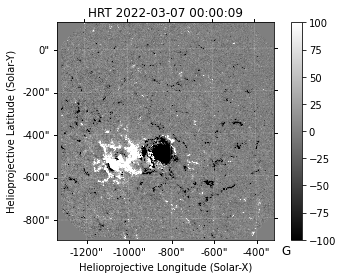

In [12]:
hrt_blos_map.plot_settings['norm'].vmin = -100
hrt_blos_map.plot_settings['norm'].vmax = 100
hrt_blos_map.peek()

## Data size

It is always good to know how big the data files are when you are handling them.

- Each data product is 2048 x 2048 pixels (16MB for 32bit pixels) 

Stokes files are an exception however:

## Stokes Data Size

- HRT: it is a datacube of: 2048 x 2048 x 4 x 6 (384MB for 32bit pixels)
- FDT: it is a datacube of: 6 x 4 x 2048 x 2048 (384MB for 32bit pixels)

The HRT stokes file will be changed in the future to match axis of the FDT

However there are times when the files are cropped, as only part of the FOV is of interest, in which case the file sizes are smaller.

The FDT data files which we use here are cropped to the central 1024 x 1024 pixels

## 2. L2 SO/PHI Data Products (Physical Observables)

The physical observables that SO/PHI creates for both telescopes: HRT and FDT, at the L2 level are:

- Continuum Intensity *[Normalised Intensity (No Unit)]*
- Vector Magnetic Field **B**:
    - Magnetic Field Strength *[Gauss]*
    - Magnetic Field Inclination *[Degrees]*
    - Magnetic Field Azimuth (Ambiguated) *[Degrees]*
- Line-of-sight Magnetic Field (Blos) *[Gauss]*
- Line-of-sight Velocity *[km/s]*

Talk about detector vector for example?



## FDT

From the vlos map, you can see that the images are not pointed with Solar North up. This must be taken into account when post-processing these images later

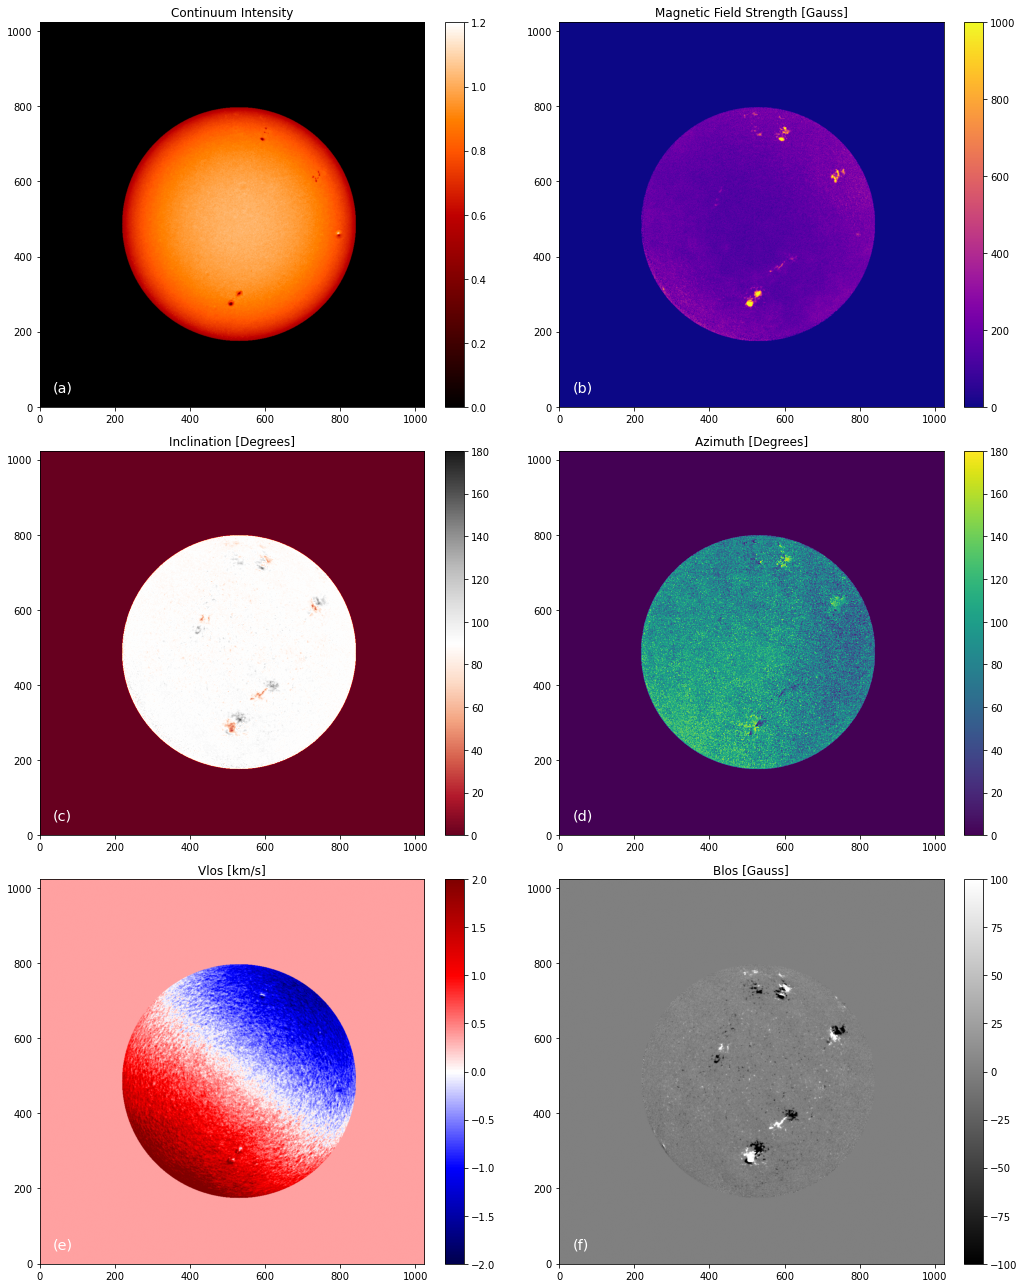

In [13]:
#show all data products, bmag, binc, bazi, blos, icnt
data_products_fdt = np.asarray([fdt_icnt_arr, fdt_bmag_arr, fdt_binc_arr, fdt_bazi_arr, fdt_vlos_arr, fdt_blos_arr])
plot_fdt_phys_obs(data_products_fdt)

## HRT

- The black edge here is the field stop region of HRT (not in the FOV of the telescope)

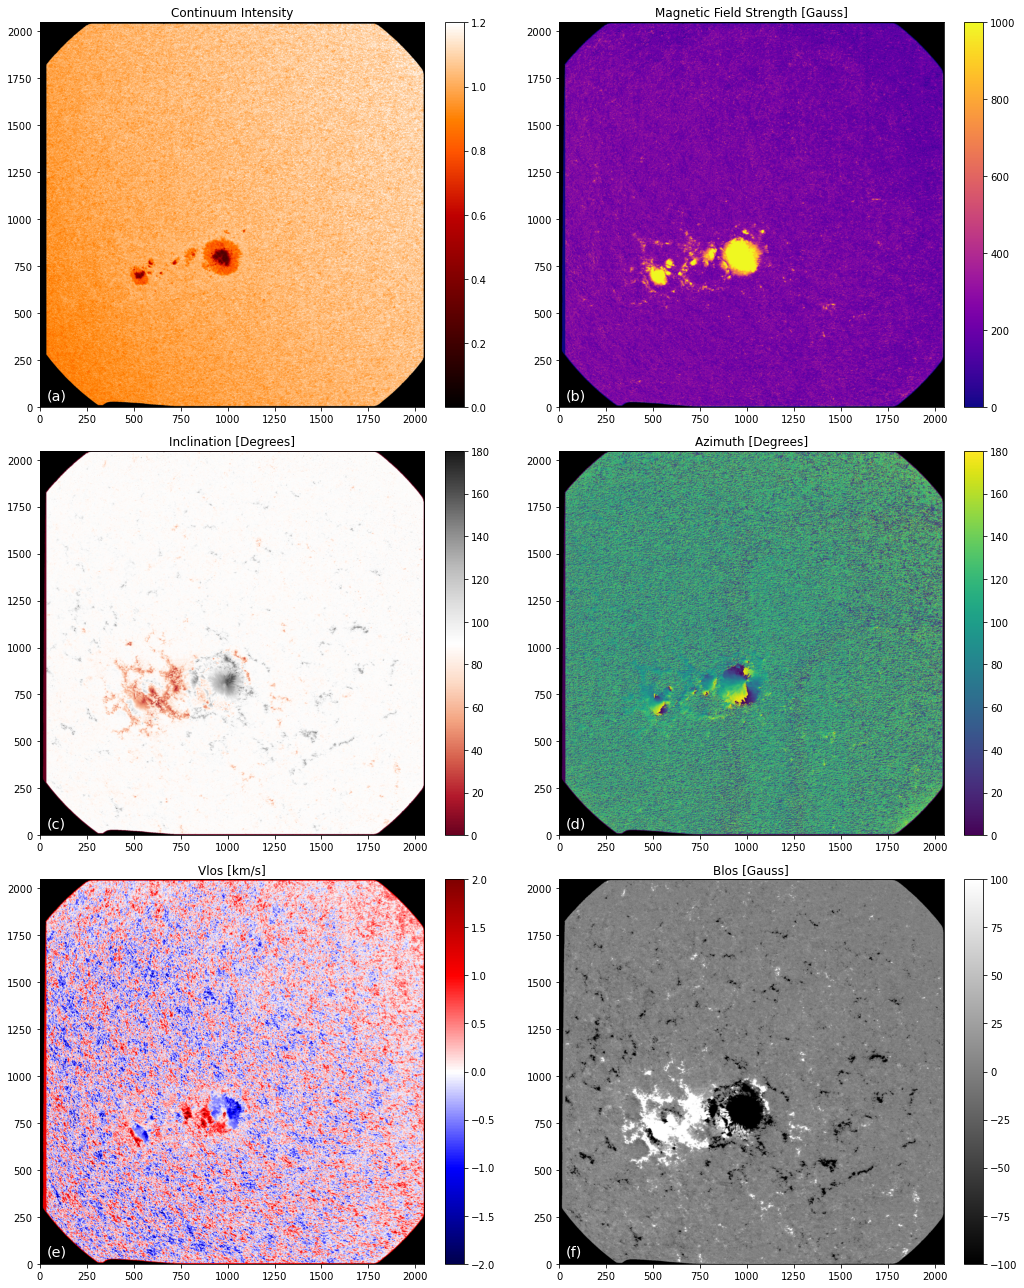

In [14]:
#show all data products, bmag, binc, bazi, blos, icnt
data_products_hrt = np.asarray([hrt_icnt_arr, hrt_bmag_arr, hrt_binc_arr, hrt_bazi_arr, hrt_vlos_arr, hrt_blos_arr])
plot_hrt_phys_obs(data_products_hrt)

## 3. Important to note: *Light Travel Time*

- Solar Orbiter is moving on an elliptical orbit, so its distance to the Sun will change over the course of its orbit.


- Should you want to compare this Solar Orbiter data to Earth-based instruments (eg: SDO/Hinode/SOHO) you might need to take care of light travel time

In [15]:
#Light travel Time, use DATE_EAR for light corrected (also DATE_SUN available)

hrt_hdr = fits.getheader(hrt_dir + "solo_L2_phi-hrt-blos_20220307T000009_V202206021608_0243070101.fits.gz")
print("Date Observed : ", hrt_hdr["DATE-OBS"], "<--- This is the start time of the observation that SOAR queries on") 
print("Average Date  : ", hrt_hdr["DATE-AVG"], "<--- Notice the 23 second difference")
print("Light Travel Time Corrected: ", hrt_hdr["DATE_EAR"], "<--- Notice the ~ 4 minute difference")

Date Observed :  2022-03-07T00:00:09.388 <--- This is the start time of the observation that SOAR queries on
Average Date  :  2022-03-07T00:00:32.393 <--- Notice the 23 second difference
Light Travel Time Corrected:  2022-03-07T00:04:14.282 <--- Notice the ~ 4 minute difference


With a time difference of over 4 minutes, this is important when comparing SO/PHI data to that from other instruments, such as SDO/HMI, especially when you are using their high cadence (45second) observables.

Here you can also access this information from the `meta` attributes from the Sunpy `Map` object.

**Sidenote:** SDO is not at exactly 1AU, so this may make a difference when the PHI data product time (light corrected) lies in the middle between two SDO datasets

In [16]:
hrt_blos_map.meta['DATE_EAR']

'2022-03-07T00:04:14.282'

## 4. Image Stabilisation System (not relevant for FDT)

- on the HRT increased pointing accuracy is required 

- hence an Image Stabilisation System (ISS) is available for the HRT only

- sometimes this system is turned off 

- when off this results in a slight noise level increase:

    - Stokes V noise from 1e-3 -->> ~1.3e-3

In [17]:
#Check if ISS on HRT is off or on

print("Image Stabilisation System Status: ", hrt_hdr["ISSMODE1"], " sunpy: ", hrt_blos_map.meta['ISSMODE1'])
print("ISS_IDLE means it was not operating")

Image Stabilisation System Status:  ISS_IDLE  sunpy:  ISS_IDLE
ISS_IDLE means it was not operating


## 5. Stokes Maps

- To produce the beautiful data products above, the Stokes information (which is what PHI measures) are put through the Radiative Transfer Equation Inversion (CMILOS)

- If you are interested in the raw Stokes Profiles, that is also available as a L2 data product

- PHI measures the Stokes IQUV vector at 5 wavelength points in the Fe1 6173A line, + one continuum wavelenght point (either red or blue dependent on the Spacecraft's velocity)

- $<I_c>$ here is the averaged Stokes **I** signal at the **C**ontinuum wavelength position

## FDT

#### reminder: fdt_stokes (uncropped) is 6 x 4 x 2048 x 2048 (wavelength, stokes, y, x)

For this FDT dataset (which is cropped to 1024 x 1024), the continuum is on the red side.

We can confirm this using the `get_wv_arr_and_ic_wv` function which calculates the wavelength positions from the FITS header

In [18]:
fdt_wave_axis, _, fdt_cpos = get_wv_arr_and_ic_wv(fdt_dir + "solo_L2_phi-fdt-stokes_20220131T143008_V202206301253_0241310515.fits.gz")
print("The wavelength positions are: ", fdt_wave_axis)
print("The continuum wavelength position is at index: ", fdt_cpos)

The wavelength positions are:  [6172.9485979 6173.017804  6173.0877127 6173.1576214 6173.2268275
 6173.3838586]
The continuum wavelength position is at index:  5


Now we encourage you to plot `fdt_stokes_arr` at different wavelengths to visualise the step across the line

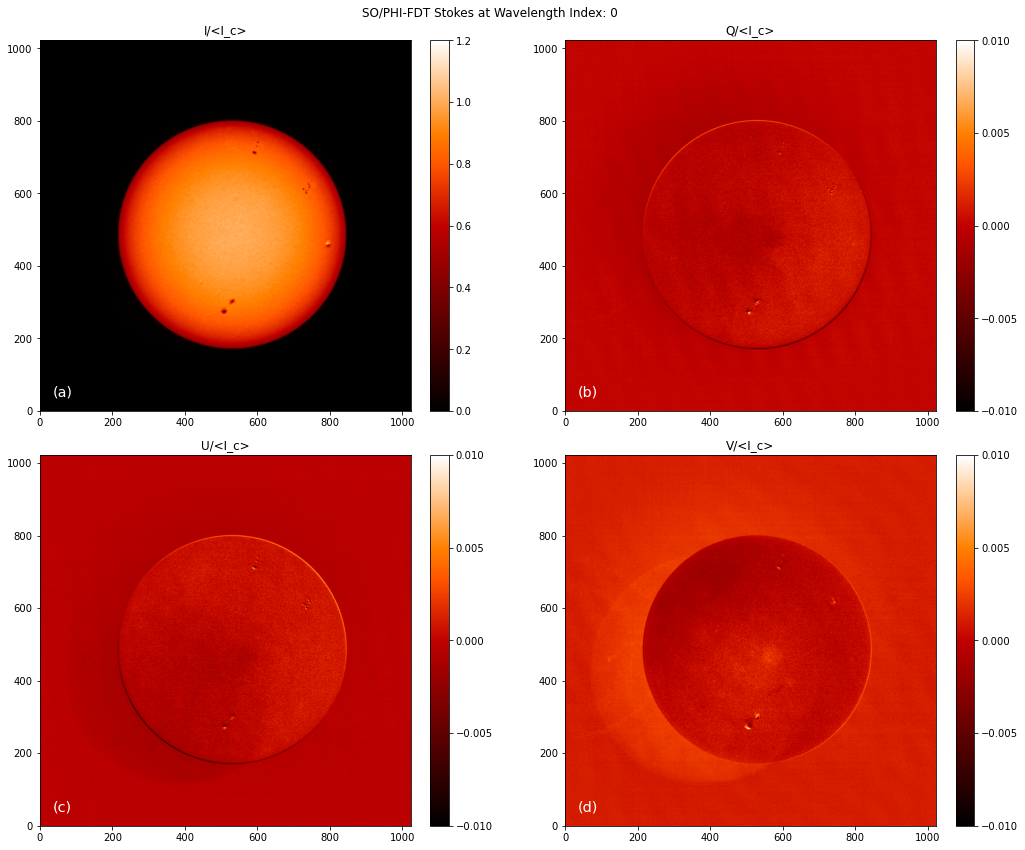

In [19]:
fdt_wv = 0 #between 0 and 5
plot_fdt_stokes(fdt_stokes_arr, fdt_wv)

## HRT

#### reminder: hrt_stokes is 2048 x 2048 x 4 x 6 (y, x, stokes, wavelength)

For this HRT dataset, the continuum is on the red side

In [20]:
hrt_wave_axis, _, hrt_cpos = get_wv_arr_and_ic_wv(hrt_dir + "solo_L2_phi-hrt-stokes_20220307T000009_V202206021608_0243070101.fits.gz")
print("The wavelength positions are: ", hrt_wave_axis)
print("The continuum wavelength position is at index: ", hrt_cpos)

The wavelength positions are:  [6172.9535161 6173.0227222 6173.0922796 6173.1621883 6173.2317457
 6173.3887768]
The continuum wavelength position is at index:  5


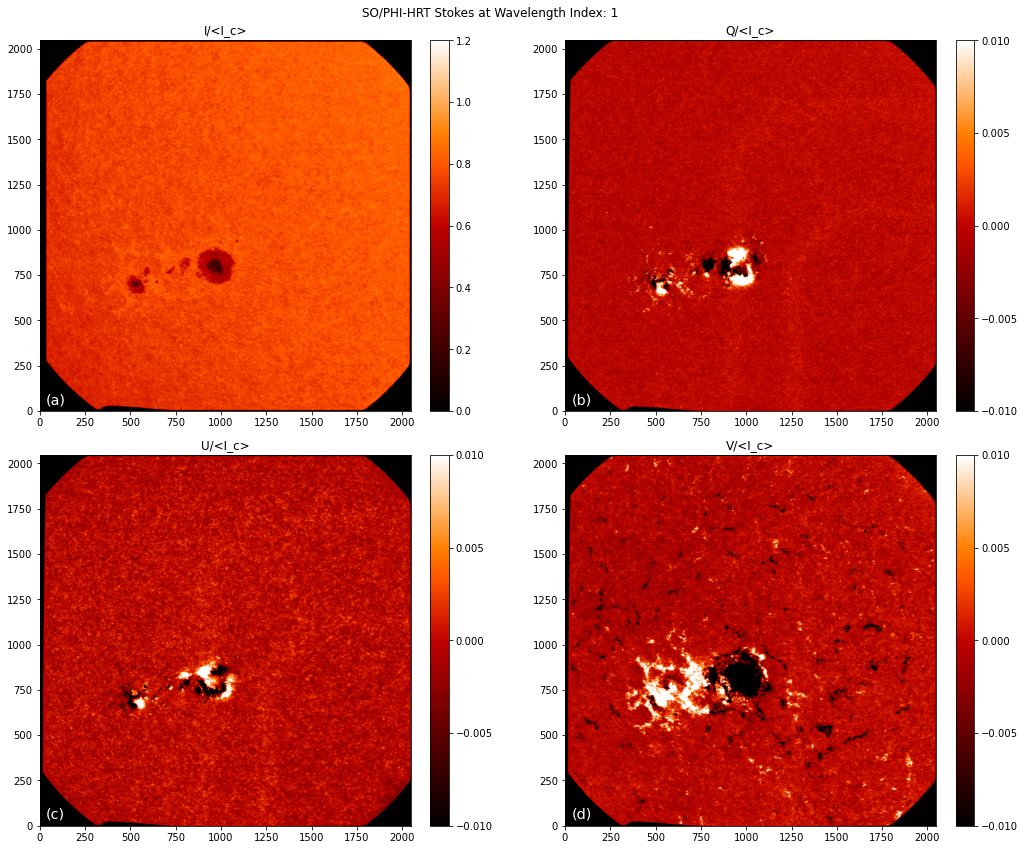

In [21]:
hrt_wv = 1 #between 0 and 5
plot_hrt_stokes(hrt_stokes_arr, hrt_wv)

## 6. HRT Noise Level Estimation

Stokes V noise is: 1.3763e-03


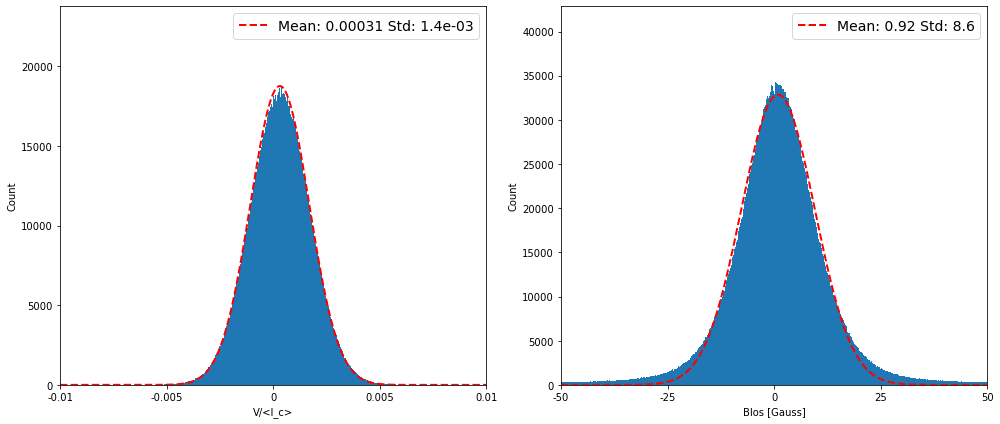

In [22]:
Stokes_V_vector = 3 #I,Q,U,V hence V index == 3
Continuum_wavelength = 5 #For this dataset the continuum is in the 5th wavelength position

plot_hrt_noise_both(hrt_stokes_arr[:,:,Stokes_V_vector,Continuum_wavelength], hrt_blos_arr)

## 7. FDT-HMI Multi Instrument Mapping

Let's say you want to compare the Blos from SO/PHI-FDT to that from SDO/HMI. We therefore need to reproject SO/PHI-FDT onto the HMI Plane.

Here we load the HMI dataset that we want to work with.

In [23]:
#here we load the HMI Magnetogram that corresponds to the same time (light travel corrected!) and taking into account UTC vs TAI difference of 37 seconds
hmi_dir = "/data/slam/home/sinjan/hmi_hrt_cc/hmi_files/blos_45/"
hmi_blos_map = sunpy.map.Map(hmi_dir + "hmi.m_45s.20220131_143215_TAI.2.magnetogram.fits")
hmi_blos_map.plot_settings['norm'].vmin = -100
hmi_blos_map.plot_settings['norm'].vmax = 100 
hmi_blos_map.plot_settings['cmap'] = plt.get_cmap('gray')

We need to rotate the HMI map by around 180 degrees, to point Solar North up

In [24]:
hmi_blos_map = hmi_blos_map.rotate(recenter = True)

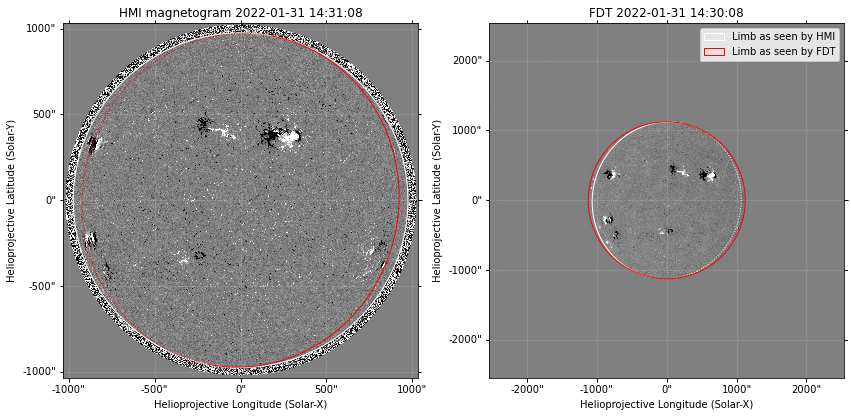

In [25]:
fig = plt.figure(figsize = (14,14))

ax1 = fig.add_subplot(121, projection=hmi_blos_map)
hmi_blos_map.plot(axes=ax1)
hmi_blos_map.draw_limb(axes=ax1, color='white')
fdt_blos_map.draw_limb(axes=ax1, color='red')

ax2 = fig.add_subplot(122, projection=fdt_blos_map)
fdt_blos_map.plot(axes=ax2)
limb_hmi = hmi_blos_map.draw_limb(axes=ax2, color='white')
limb_fdt = fdt_blos_map.draw_limb(axes=ax2, color='red')

plt.legend([limb_hmi[0], limb_fdt[0]],
           ['Limb as seen by HMI', 'Limb as seen by FDT'])

First we can use the inbuilt reprojection algorithm in sunpy, which uses the WCS information within the header of the FITS file, to remap it onto the HMI's FOV.

We have to create an out_header using `sunpy.map.make_fitswcs_header` to be the output of the fdt remapped image.

In [26]:
#Show how to rotate FDT onto HMI plane
out_shape = fdt_blos_map.data.shape

out_header = sunpy.map.make_fitswcs_header(
    out_shape,
    hmi_blos_map.reference_coordinate.replicate(rsun=fdt_blos_map.reference_coordinate.rsun),
    scale=u.Quantity(fdt_blos_map.scale),
    instrument="PHI",
    observatory="HMI Observer"
)

In [27]:
fdt_blos_map.data.shape

(1422, 1422)

Now we apply the reprojection (this can take 30 seconds or longer)

In [28]:
fdt_outmap = fdt_blos_map.reproject_to(out_header, algorithm = "adaptive")

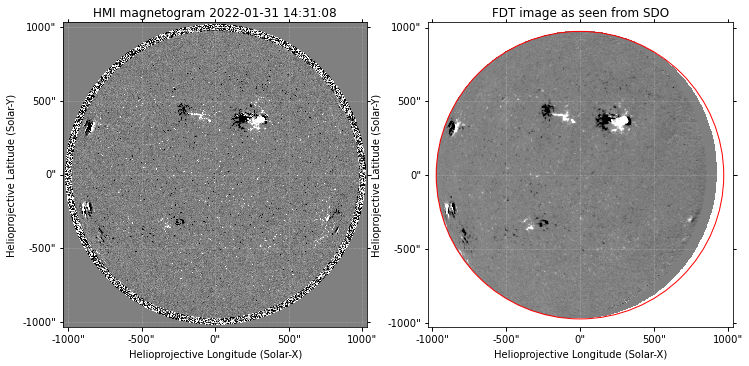

In [29]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121, projection=hmi_blos_map)
hmi_blos_map.plot(axes=ax1)
ax2 = fig.add_subplot(122, projection=fdt_outmap)
fdt_outmap.plot(axes=ax2, title='FDT image as seen from SDO', autoalign = True)
ax2.set_ylim(423,1000) #matching the axes limits of the HMI image
ax2.set_xlim(423,1000)
hmi_limb = hmi_blos_map.draw_limb(axes=ax2, color='red', label = "Limb as seen by HMI")

## 8. HRT-HMI Multi Instrument Mapping

Here we can use the inferior conjunction data to compare HRT and HMI magnetograms with almost the same viewpoint on the Photosphere (still off by approximately 4 degrees).

In [30]:
#here we load the HMI Magnetogram that corresponds to the same time (light travel corrected!) and taking into account UTC vs TAI difference of 37 seconds
hmi_dir = "/data/slam/home/sinjan/hmi_hrt_cc/hmi_files/blos_45/"
hmi_map = sunpy.map.Map(hmi_dir + "hmi.m_45s.20220307_000430_TAI.2.magnetogram.fits")
hmi_map.plot_settings['norm'].vmin = -100
hmi_map.plot_settings['norm'].vmax = 100

We need to rotate the HMI map by 180 degrees

In [31]:
hmi_m = hmi_map.rotate(180 * u.deg)

Now let's plot the two side by side as a comparison

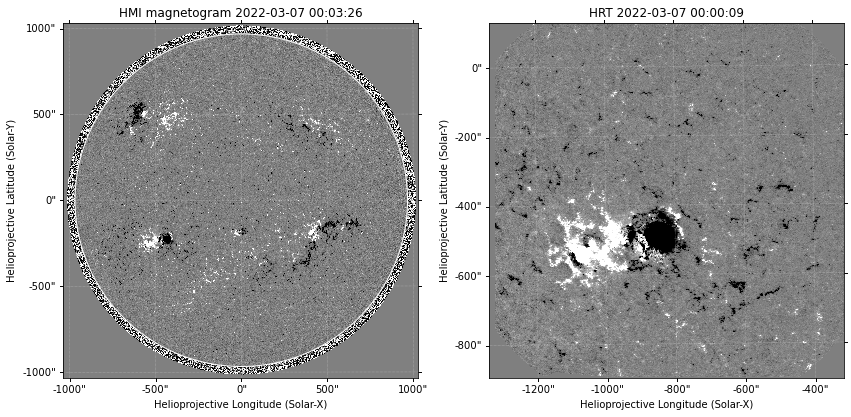

In [32]:
fig = plt.figure(figsize = (14,14))

ax1 = fig.add_subplot(121, projection=hmi_m)
hmi_m.plot(axes=ax1)
hmi_m.draw_limb(axes=ax1, color='white')

ax2 = fig.add_subplot(122, projection=hrt_blos_map)
hrt_blos_map.plot(axes=ax2)

Here we can plot the exact FOV of HRT on the HMI plane, using the `bottom_left_coord` and the `top_right_coord` attribute

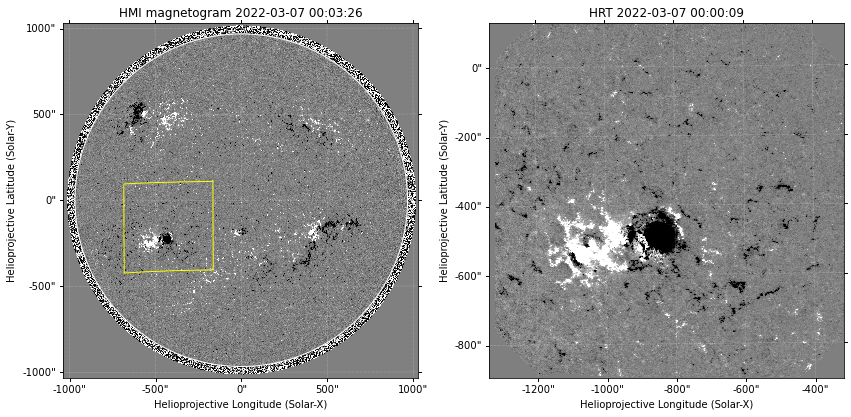

In [37]:
from astropy.coordinates import SkyCoord
from sunpy.coordinates import HeliographicStonyhurst

fig = plt.figure(figsize = (14,14))

ax1 = fig.add_subplot(121, projection=hmi_m)
hmi_m.plot(axes=ax1)
hmi_m.draw_limb(axes=ax1, color='white')
bottom_left = hrt_blos_map.bottom_left_coord
top_right = hrt_blos_map.top_right_coord
hmi_m.draw_quadrangle(bottom_left, top_right=top_right, axes = ax1, edgecolor='yellow') #width = 1024*u.arcsec, height = 1024*u.arcsec
ax2 = fig.add_subplot(122, projection=hrt_blos_map)
hrt_blos_map.plot(axes=ax2)